In [1]:
%matplotlib inline
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.finfo(np.float32).eps, np.sqrt(np.finfo(np.float32).eps), np.power(np.finfo(np.float32).eps, 0.7)

(1.1920929e-07, 0.00034526698, 1.4236953606213502e-05)

In [3]:
np.finfo(np.float64).eps, np.sqrt(np.finfo(np.float64).eps)

(2.220446049250313e-16, 1.4901161193847656e-08)

In [4]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib/keras_ex')
from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from gkernel.sklearn import (
    RBFClassifier, RBFRegressor,
    make_model_gkernel3,
    make_model_gkernel2,
    make_model_gkernel1,
    make_model_out,
    make_model
)

In [5]:
iris = datasets.load_iris()
X = iris.data.astype(np.float32)
Y = iris.target
N = Y.size
Y2 = keras.utils.to_categorical(Y, num_classes=3)

index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = Y2[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = Y2[index[index % 2 == 0]]

In [6]:
#lm, model_gkernel = make_model_gkernel2()
lm, model_gkernel = make_model_gkernel3()
print(model_gkernel.inputs[0])
model_gkernel.summary()

W1002 08:37:50.812715 139829843625792 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 08:37:50.834200 139829843625792 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1002 08:37:50.849268 139829843625792 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1002 08:37:50.850111 139829843625792 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. P

Tensor("inp:0", shape=(?, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 4)                 0         
_________________________________________________________________
gkernel (GaussianKernel3)    (None, 2)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_out = make_model_out()
model_out.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = make_model(nn=4, num_cls=3, make_model_gkernel=make_model_gkernel3)
model.summary()

W1002 08:37:51.121981 139829843625792 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 4)                 0         
_________________________________________________________________
model_gkernel (Model)        (None, 2)                 9         
_________________________________________________________________
model_out (Model)            (None, 3)                 9         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(xtrain, ytrain, epochs=5, verbose=2)

W1002 08:37:51.256402 139829843625792 deprecation.py:323] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
 - 1s - loss: 1.1008 - acc: 0.2267
Epoch 2/5
 - 0s - loss: 1.0989 - acc: 0.3333
Epoch 3/5
 - 0s - loss: 1.0991 - acc: 0.3333
Epoch 4/5
 - 0s - loss: 1.0986 - acc: 0.2800
Epoch 5/5
 - 0s - loss: 1.0980 - acc: 0.3333


In [10]:
pred = model.predict(xtrain)
pred[:5]

array([[0.3411307 , 0.3175701 , 0.34129924],
       [0.34247687, 0.3158486 , 0.34167457],
       [0.33900255, 0.32030657, 0.34069094],
       [0.34001616, 0.31900483, 0.34097904],
       [0.3408608 , 0.31791964, 0.34121957]], dtype=float32)

In [11]:
np.random.choice(np.arange(xtrain.shape[0]), 3)

array([51, 68, 21])

In [12]:
model.save('saved_model')

In [13]:
ls -la

合計 5020
drwxrwxr-x. 3 admin admin     154 10月  1 23:55 ./
drwxrwxr-x. 7 admin admin    4096  9月 16 10:46 ../
drwxr-xr-x. 2 admin admin     153  9月 29 23:43 .ipynb_checkpoints/
-rw-rw-r--. 1 admin admin  880913 10月  1 23:55 dev_001.ipynb
-rw-rw-r--. 1 admin admin  321501 10月  1 23:05 dev_002-digits8.ipynb
-rw-rw-r--. 1 admin admin 2332206 10月  1 23:35 dev_003-moon.ipynb
-rw-rw-r--. 1 admin admin 1568749 10月  1 23:34 dev_004-moon2.ipynb
-rw-rw-r--. 1 admin admin   24384 10月  2 08:37 saved_model


In [14]:
from keras.models import load_model

In [15]:
# load_model('saved_model', custom_objects={'GaussianKernel2': GaussianKernel2})
m = load_model('saved_model', custom_objects={'GaussianKernel3': GaussianKernel3})

In [16]:
pred = m.predict(xtrain)
pred[:5]

array([[0.3411307 , 0.3175701 , 0.34129924],
       [0.34247687, 0.3158486 , 0.34167457],
       [0.33900255, 0.32030657, 0.34069094],
       [0.34001616, 0.31900483, 0.34097904],
       [0.3408608 , 0.31791964, 0.34121957]], dtype=float32)

## Getting Started

In [17]:
'''
number of landmarks is 3
'''
clf = RBFClassifier(
    num_lm=15,
    lm_select_from_x=True
)

In [18]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 2.4 s, sys: 89.3 ms, total: 2.49 s
Wall time: 2.15 s


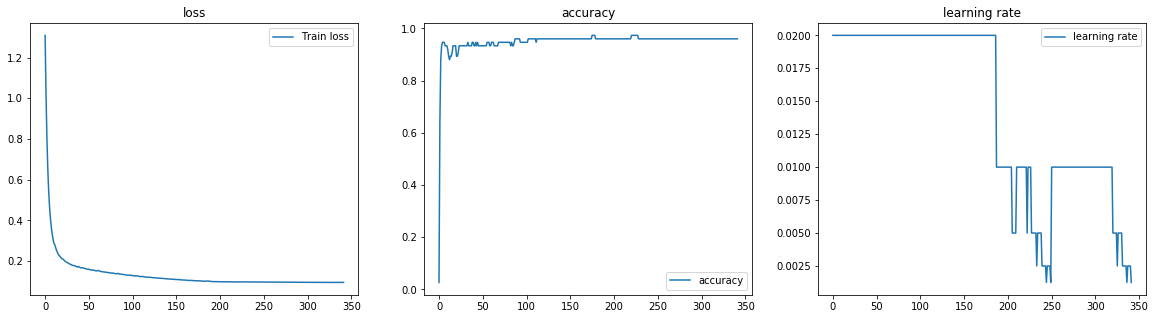

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [20]:
'''
trained gamma
'''
clf.current_gamma()

0.68538666

In [21]:
'''
fixed landmarks
'''
lm = clf.current_lm()
lm

array([[6.1, 2.9, 4.7, 1.4],
       [5. , 2.3, 3.3, 1. ],
       [6.3, 2.7, 4.9, 1.8],
       [5. , 3.2, 1.2, 0.2],
       [6.4, 3.1, 5.5, 1.8],
       [6.4, 3.2, 4.5, 1.5],
       [7.2, 3.6, 6.1, 2.5],
       [7.7, 3. , 6.1, 2.3],
       [5. , 3.3, 1.4, 0.2],
       [5.2, 3.5, 1.5, 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [6.1, 2.8, 4.7, 1.2],
       [5. , 3. , 1.6, 0.2],
       [6.4, 3.2, 5.3, 2.3],
       [7.2, 3. , 5.8, 1.6]], dtype=float32)

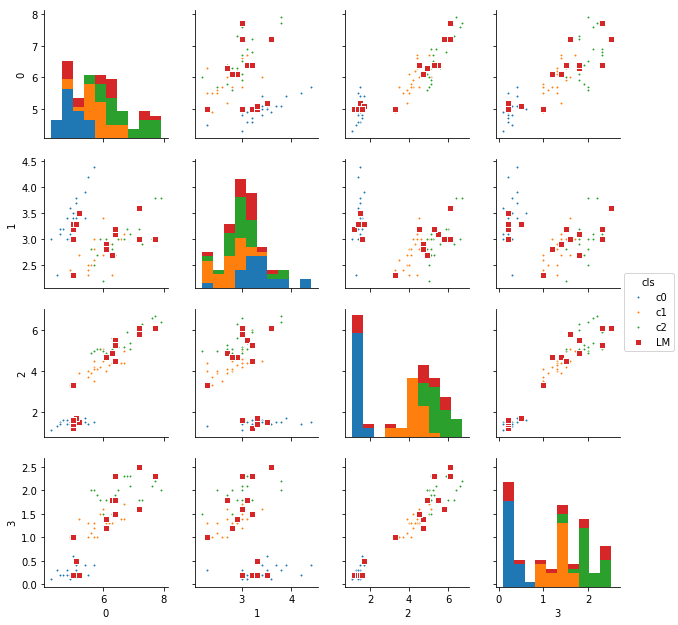

In [22]:
df = pd.DataFrame(np.r_[xtrain, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['LM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['s'], hue='cls', size=2.2, diag_kind='hist')

In [23]:
clf.predict_proba(xtest)[:5]

array([[9.99855995e-01, 8.05313030e-05, 6.34461830e-05],
       [9.99715388e-01, 1.71140200e-04, 1.13509253e-04],
       [9.99792635e-01, 1.12376685e-04, 9.49864407e-05],
       [9.99562323e-01, 2.49221892e-04, 1.88401391e-04],
       [9.97422576e-01, 1.50792627e-03, 1.06956903e-03]], dtype=float32)

In [24]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [25]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9599839935974389
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      0.92      0.94        25
           2       0.92      0.96      0.94        25

   micro avg       0.96      0.96      0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

[[25  0  0]
 [ 0 23  2]
 [ 0  1 24]]


In [26]:
pred_test = clf.predict(xtest)

In [27]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9599839935974389
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.92      0.96      0.94        25
           2       0.96      0.92      0.94        25

   micro avg       0.96      0.96      0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

[[25  0  0]
 [ 0 24  1]
 [ 0  2 23]]


## set landmarks on input x

In [28]:
clf = RBFClassifier(
    num_lm=3,
    lm=xtrain[:3]
)

In [29]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 5.83 s, sys: 169 ms, total: 6 s
Wall time: 4.84 s


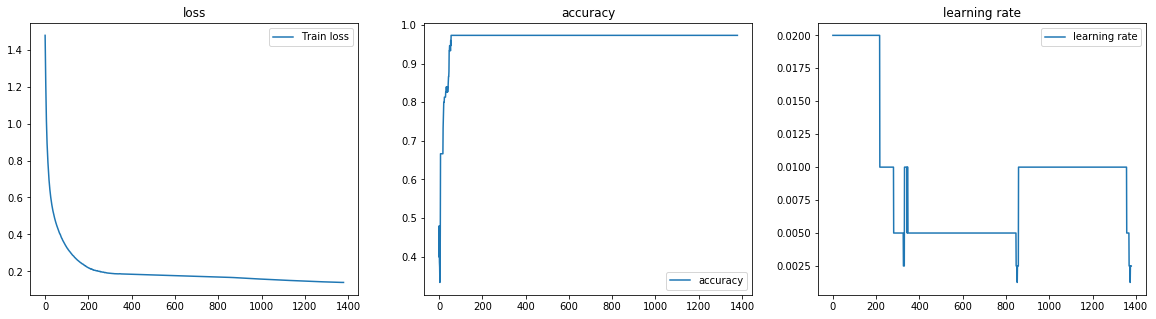

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [31]:
'''
trained gamma
'''
clf.current_gamma()

0.13195604

In [32]:
'''
fixed landmarks
'''
lm = clf.current_lm()
lm

array([[4.9, 3. , 1.4, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5.4, 3.9, 1.7, 0.4]], dtype=float32)

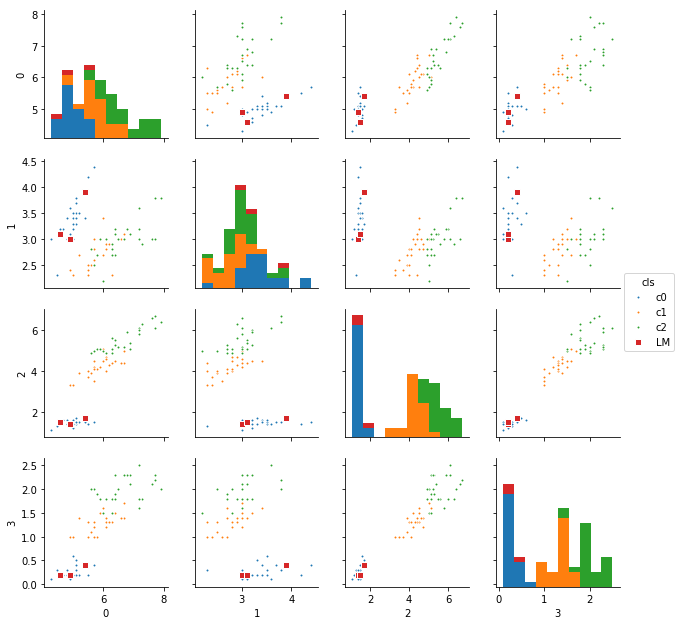

In [33]:
df = pd.DataFrame(np.r_[xtrain, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['LM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['s'], hue='cls', size=2.2, diag_kind='hist')

In [34]:
clf.predict_proba(xtest)[:5]

array([[9.8549217e-01, 1.4507778e-02, 1.5583804e-12],
       [9.8535931e-01, 1.4640689e-02, 2.5077648e-12],
       [9.8488241e-01, 1.5117610e-02, 1.7650193e-12],
       [9.8469907e-01, 1.5300966e-02, 2.5964493e-12],
       [9.7675008e-01, 2.3249893e-02, 1.5625522e-11]], dtype=float32)

In [35]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [36]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9732905982905983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.92      0.96        25
           2       0.93      1.00      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75

[[25  0  0]
 [ 0 23  2]
 [ 0  0 25]]


In [37]:
pred_test = clf.predict(xtest)

In [38]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9063294526963737
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.91      0.80      0.85        25
           2       0.82      0.92      0.87        25

   micro avg       0.91      0.91      0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

[[25  0  0]
 [ 0 20  5]
 [ 0  2 23]]


## set landmarks on input x randomly

In [39]:
clf = RBFClassifier(
    num_lm=3,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 3, replace=False)]
)

In [40]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 2.98 s, sys: 83.6 ms, total: 3.07 s
Wall time: 2.63 s


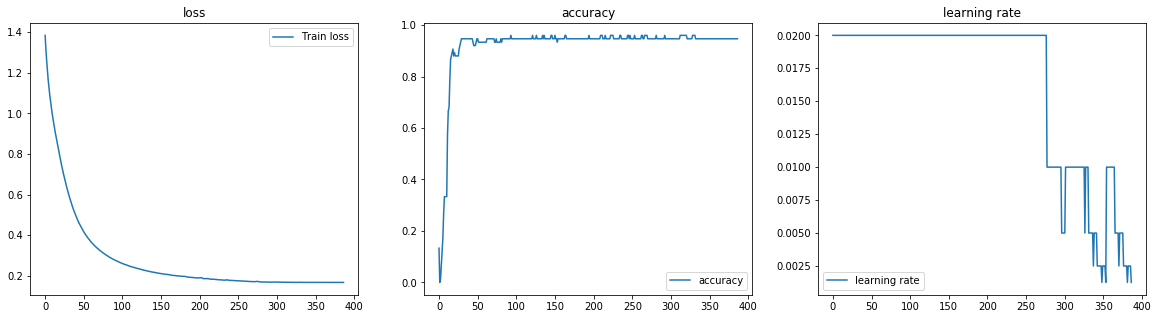

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [42]:
'''
trained gamma
'''
clf.current_gamma()

0.21604988

In [43]:
'''
fixed landmarks
'''
lm = clf.current_lm()
lm

array([[6.7, 3. , 5.2, 2.3],
       [5.6, 2.5, 3.9, 1.1],
       [6.1, 2.8, 4.7, 1.2]], dtype=float32)

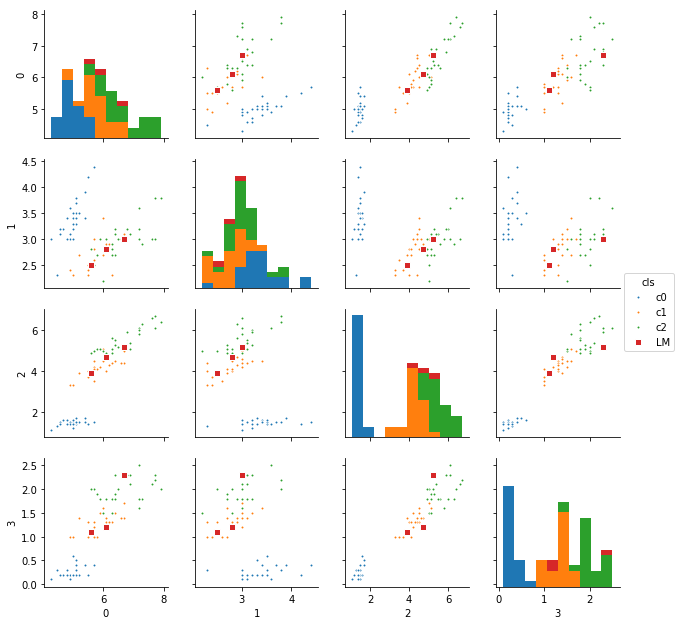

In [44]:
df = pd.DataFrame(np.r_[xtrain, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['LM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['s'], hue='cls', size=2.2, diag_kind='hist')

In [45]:
clf.predict_proba(xtest)[:5]

array([[0.9658405 , 0.01092915, 0.02323032],
       [0.968762  , 0.00895942, 0.02227857],
       [0.9667673 , 0.00997784, 0.02325488],
       [0.96803075, 0.00946687, 0.02250247],
       [0.9690341 , 0.00925115, 0.02171483]], dtype=float32)

In [46]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [47]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9466666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.92      0.92      0.92        25
           2       0.92      0.92      0.92        25

   micro avg       0.95      0.95      0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75

[[25  0  0]
 [ 0 23  2]
 [ 0  2 23]]


In [48]:
pred_test = clf.predict(xtest)

In [49]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9057239057239057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.95      0.76      0.84        25
           2       0.80      0.96      0.87        25

   micro avg       0.91      0.91      0.91        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.92      0.91      0.91        75

[[25  0  0]
 [ 0 19  6]
 [ 0  1 24]]


## set landmarks on input x randomly (num_lm = 25)

In [50]:
num_lm = 25
clf = RBFClassifier(
    num_lm=num_lm,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), num_lm)]
)

In [51]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 2.81 s, sys: 74.6 ms, total: 2.89 s
Wall time: 2.47 s


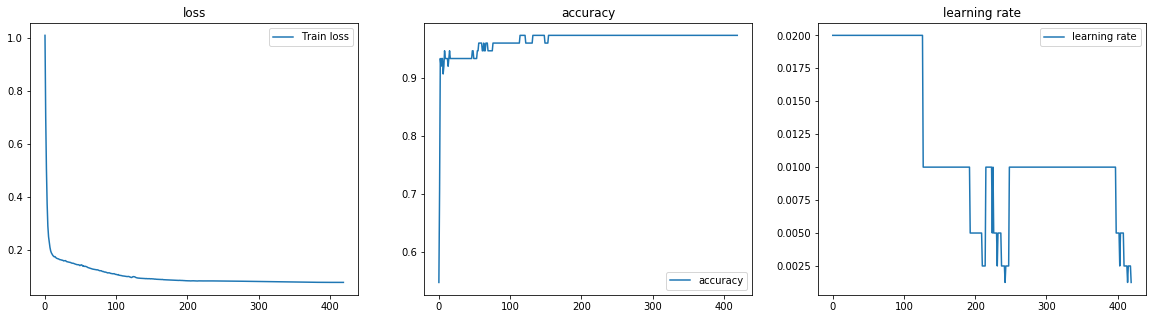

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [53]:
'''
trained gamma
'''
clf.current_gamma()

0.90872353

In [54]:
'''
fixed landmarks
'''
lm = clf.current_lm()
lm

array([[6.7, 3. , 5. , 1.7],
       [5.5, 4.2, 1.4, 0.2],
       [5. , 3.4, 1.5, 0.2],
       [6.3, 2.3, 4.4, 1.3],
       [5.7, 2.8, 4.5, 1.3],
       [5.1, 3.3, 1.7, 0.5],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 2.7, 3.9, 1.4],
       [6.3, 2.7, 4.9, 1.8],
       [7.2, 3. , 5.8, 1.6],
       [7.2, 3.2, 6. , 1.8],
       [5.2, 3.5, 1.5, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [4.9, 2.4, 3.3, 1. ],
       [4.9, 3.6, 1.4, 0.1],
       [5.5, 2.3, 4. , 1.3],
       [6.7, 3. , 5. , 1.7],
       [7.2, 3.2, 6. , 1.8],
       [6.1, 2.8, 4. , 1.3],
       [5.5, 2.4, 3.7, 1. ],
       [6.1, 3. , 4.9, 1.8],
       [6.8, 3.2, 5.9, 2.3],
       [7.2, 3.6, 6.1, 2.5],
       [6.4, 2.7, 5.3, 1.9],
       [5.5, 4.2, 1.4, 0.2]], dtype=float32)

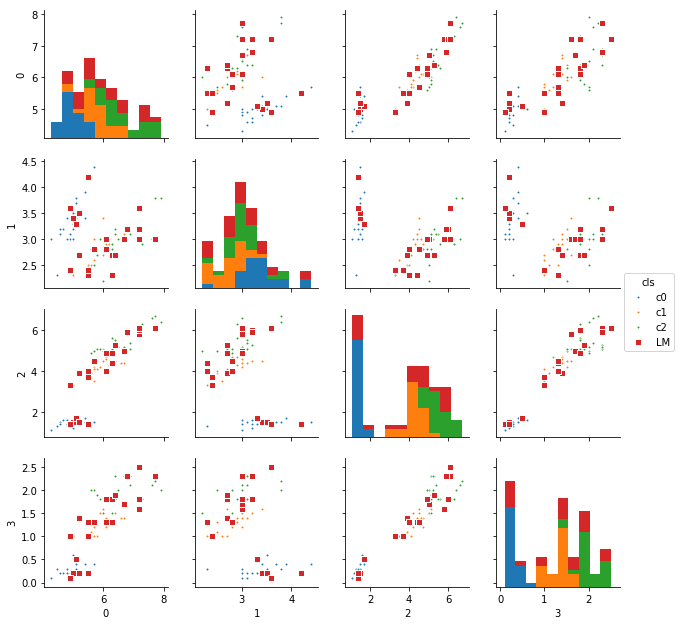

In [55]:
df = pd.DataFrame(np.r_[xtrain, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['LM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['s'], hue='cls', size=2.2, diag_kind='hist')

In [56]:
clf.predict_proba(xtest)[:5]

array([[9.9991357e-01, 1.0133469e-05, 7.6295793e-05],
       [9.9916780e-01, 1.5278906e-04, 6.7944499e-04],
       [9.9990189e-01, 1.1060871e-05, 8.7056840e-05],
       [9.9928987e-01, 1.2499833e-04, 5.8514654e-04],
       [9.8818457e-01, 2.7142595e-03, 9.1011822e-03]], dtype=float32)

In [57]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [58]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9732905982905983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.92      0.96        25
           2       0.93      1.00      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75

[[25  0  0]
 [ 0 23  2]
 [ 0  0 25]]


In [59]:
pred_test = clf.predict(xtest)

In [60]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9733333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      0.96      0.96        25
           2       0.96      0.96      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75

[[25  0  0]
 [ 0 24  1]
 [ 0  1 24]]


## set landmarks automatically on input x
* num_lm = 25

In [61]:
num_lm = 25
clf = RBFClassifier(
    num_lm=num_lm,
    lm_select_from_x=True
)

In [62]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 2.98 s, sys: 74.6 ms, total: 3.06 s
Wall time: 2.63 s


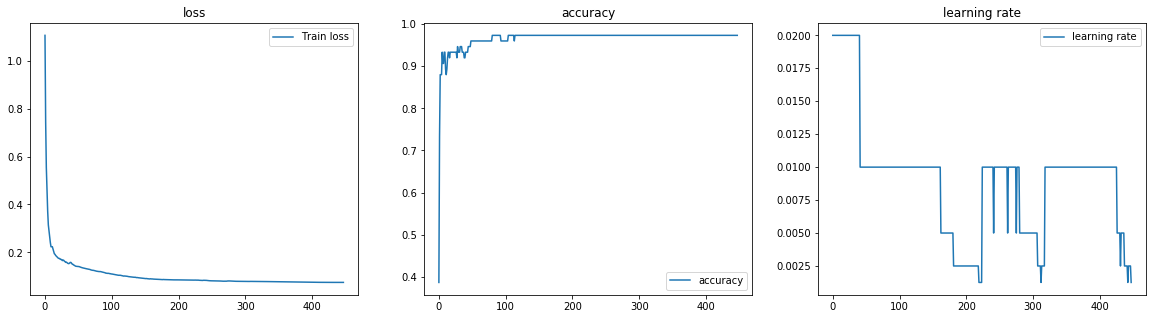

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [64]:
'''
trained gamma
'''
clf.current_gamma()

0.8578372

In [65]:
'''
fixed landmarks
'''
lm = clf.current_lm()
lm

array([[7.2, 3.2, 6. , 1.8],
       [6.4, 3.2, 5.3, 2.3],
       [6.4, 3.1, 5.5, 1.8],
       [5.9, 3. , 4.2, 1.5],
       [4.9, 2.4, 3.3, 1. ],
       [6.7, 3. , 5.2, 2.3],
       [5.5, 2.3, 4. , 1.3],
       [5.7, 2.5, 5. , 2. ],
       [5.7, 4.4, 1.5, 0.4],
       [6.9, 3.1, 5.4, 2.1],
       [6.5, 3. , 5.2, 2. ],
       [4.8, 3. , 1.4, 0.3],
       [5.5, 2.4, 3.7, 1. ],
       [5.6, 2.8, 4.9, 2. ],
       [5.1, 3.3, 1.7, 0.5],
       [6.7, 3. , 5. , 1.7],
       [4.6, 3.1, 1.5, 0.2],
       [6.3, 2.7, 4.9, 1.8],
       [6.4, 2.7, 5.3, 1.9],
       [4.9, 3.6, 1.4, 0.1],
       [7.3, 2.9, 6.3, 1.8],
       [7.9, 3.8, 6.4, 2. ],
       [6.3, 2.8, 5.1, 1.5],
       [6. , 3.4, 4.5, 1.6],
       [5.1, 3.5, 1.4, 0.3]], dtype=float32)

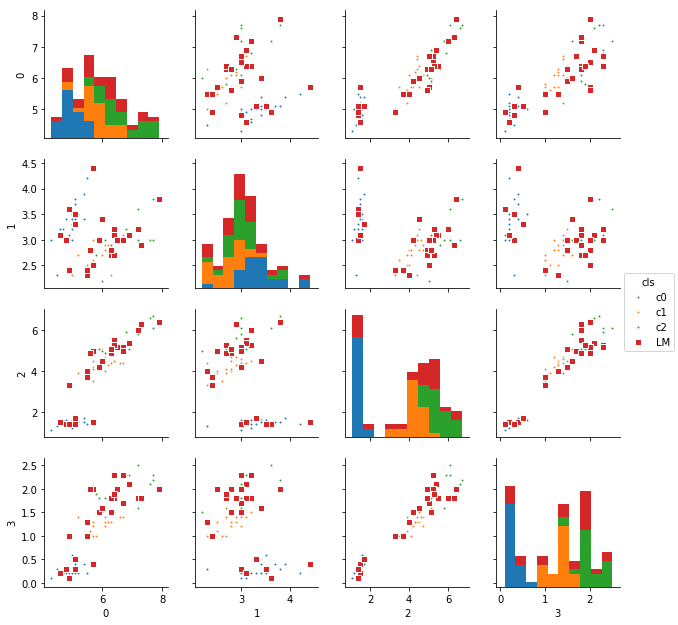

In [66]:
df = pd.DataFrame(np.r_[xtrain, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['LM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['s'], hue='cls', size=2.2, diag_kind='hist')

In [67]:
clf.predict_proba(xtest)[:5]

array([[9.9970919e-01, 2.4161983e-04, 4.9171915e-05],
       [9.9953496e-01, 3.6808604e-04, 9.6934433e-05],
       [9.9969065e-01, 2.5650745e-04, 5.2960717e-05],
       [9.9949300e-01, 4.0284346e-04, 1.0407761e-04],
       [9.9697554e-01, 2.1906681e-03, 8.3382480e-04]], dtype=float32)

In [68]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [69]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9732905982905983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.92      0.96        25
           2       0.93      1.00      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75

[[25  0  0]
 [ 0 23  2]
 [ 0  0 25]]


In [70]:
pred_test = clf.predict(xtest)

In [71]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9866613311991465
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      1.00      0.98        25
           2       1.00      0.96      0.98        25

   micro avg       0.99      0.99      0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

[[25  0  0]
 [ 0 25  0]
 [ 0  1 24]]


## set initial landmarks manually and train
* num_lm = 15
* train landmarks

In [72]:
num_lm = 15
init_lm = np.c_[
    np.random.random((num_lm,))*4+4,
    np.random.random((num_lm,))*2+2.5,
    np.random.random((num_lm,))*4+2,
    np.random.random((num_lm,))*2.5
]
# init_lm = np.c_[
#     np.random.random((num_lm,)),
#     np.random.random((num_lm,)),
#     np.random.random((num_lm,)),
#     np.random.random((num_lm,))
# ]

clf = RBFClassifier(
    num_lm=num_lm,
    lm=init_lm,
    make_model_gkernel=make_model_gkernel3
)

In [73]:
init_lm

array([[4.78074224, 3.56816464, 2.57703255, 0.25115726],
       [5.29430148, 3.75083682, 5.40945373, 0.59496294],
       [5.86566606, 4.3554174 , 4.43472395, 1.1194266 ],
       [5.0017638 , 2.75765372, 2.22905828, 0.84795255],
       [7.92425049, 2.93300384, 5.73975086, 1.35515895],
       [7.92974307, 4.31509595, 4.99110008, 0.72559044],
       [5.4061359 , 4.32183529, 4.4316468 , 0.74553072],
       [5.0943635 , 3.5254682 , 2.65664187, 2.22244756],
       [4.99085354, 4.08647352, 3.90929073, 1.80965734],
       [4.29691281, 4.12068419, 4.9006981 , 2.19669751],
       [5.65121332, 4.30550786, 3.95060609, 2.1609305 ],
       [4.28766623, 3.71481104, 2.18978466, 0.0609706 ],
       [7.30341389, 3.65489706, 4.86337517, 1.45198619],
       [7.52610138, 2.51119298, 4.36454777, 1.83717124],
       [5.5957697 , 3.03868991, 2.47034655, 1.28758403]])

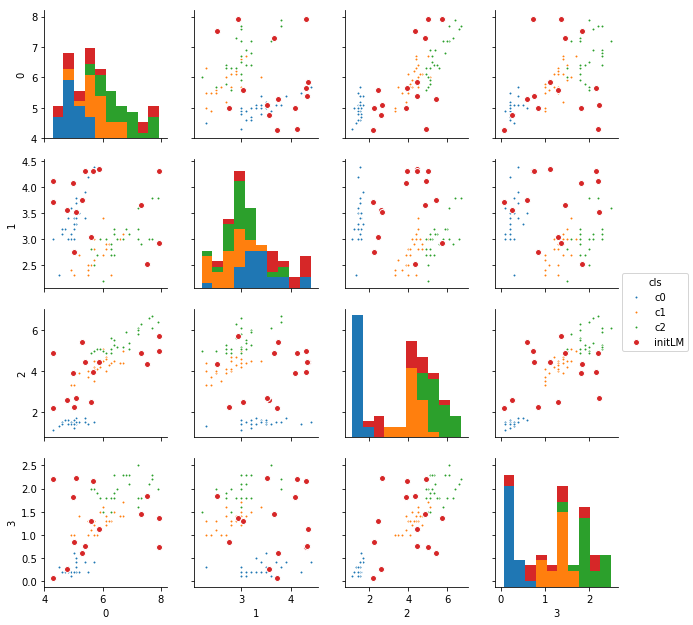

In [74]:
df = pd.DataFrame(np.r_[xtrain, init_lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o'], hue='cls', size=2.2, diag_kind='hist')

In [75]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 2.34 s, sys: 45.6 ms, total: 2.38 s
Wall time: 2.17 s


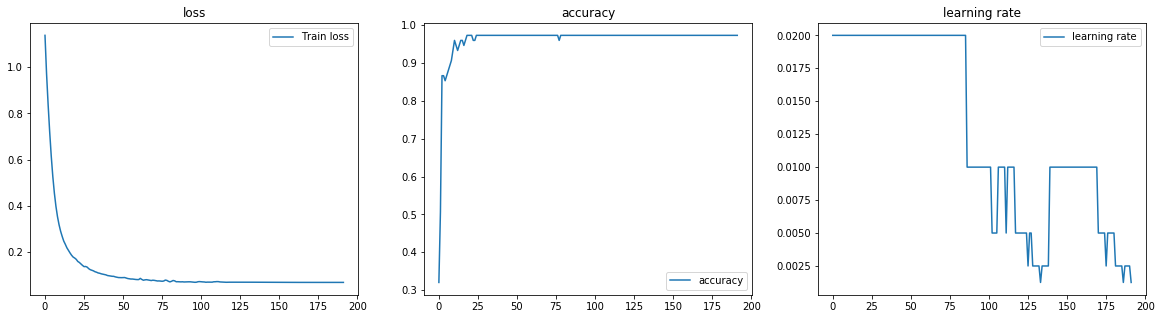

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [77]:
'''
trained gamma
'''
clf.current_gamma()

0.26869306

In [78]:
'''
trained landmarks
'''
lm = clf.current_lm()
lm

array([[4.999552  , 3.5391104 , 1.3174257 , 0.15428053],
       [5.6713805 , 2.6114964 , 4.093357  , 1.1208335 ],
       [5.929156  , 2.758318  , 5.685123  , 2.5558698 ],
       [4.998925  , 3.500595  , 1.3071884 , 0.1731757 ],
       [6.3262153 , 2.6088343 , 5.9992304 , 2.5903769 ],
       [6.7455883 , 3.2281518 , 4.089264  , 0.72345525],
       [5.9430594 , 2.817369  , 5.602487  , 2.3677988 ],
       [6.194447  , 3.2978942 , 2.7131093 , 0.7286348 ],
       [5.5783772 , 3.7864473 , 3.4531052 , 0.58436227],
       [5.71815   , 2.8535197 , 3.8688982 , 0.7172837 ],
       [6.641073  , 3.3056054 , 3.8201904 , 0.7579012 ],
       [4.8006577 , 3.5779133 , 1.6130487 , 0.1307202 ],
       [6.480558  , 2.7908444 , 6.0055623 , 2.6688635 ],
       [6.6637354 , 3.163387  , 3.9046574 , 0.8041291 ],
       [5.340753  , 3.4948401 , 1.9011865 , 0.36632803]], dtype=float32)

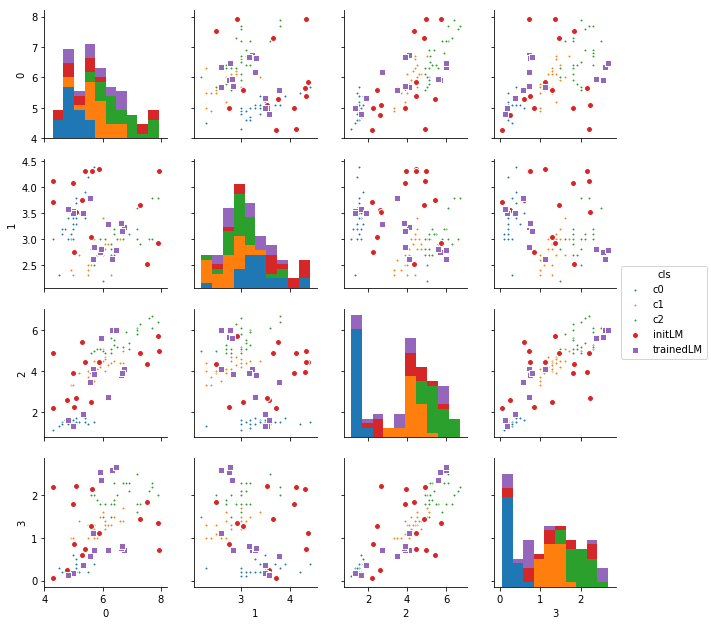

In [79]:
df = pd.DataFrame(np.r_[xtrain, init_lm, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0] + ['trainedLM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o','s'], hue='cls', size=2.2, diag_kind='hist')

In [80]:
clf.predict_proba(xtest)[:5]

array([[9.9843043e-01, 1.4652376e-03, 1.0429050e-04],
       [9.9810839e-01, 1.5910249e-03, 3.0058363e-04],
       [9.9854642e-01, 1.3381415e-03, 1.1541163e-04],
       [9.9813062e-01, 1.6039016e-03, 2.6541884e-04],
       [9.9516100e-01, 3.6911138e-03, 1.1479257e-03]], dtype=float32)

In [81]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [82]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9732905982905983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.92      0.96        25
           2       0.93      1.00      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75

[[25  0  0]
 [ 0 23  2]
 [ 0  0 25]]


In [83]:
pred_test = clf.predict(xtest)

In [84]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9866613311991465
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      1.00      0.98        25
           2       1.00      0.96      0.98        25

   micro avg       0.99      0.99      0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

[[25  0  0]
 [ 0 25  0]
 [ 0  1 24]]


## set initial landmarks manually and no train
* num_lm = 15
* train nothing, just activation

In [85]:
num_lm = 15
init_lm = np.c_[
    np.random.random((num_lm,))*4+4,
    np.random.random((num_lm,))*2+2.5,
    np.random.random((num_lm,))*4+2,
    np.random.random((num_lm,))*2.5
]

clf = RBFClassifier(
    num_lm=num_lm,
    lm=init_lm,
    gamma='scale',
    make_model_gkernel=make_model_gkernel1
)

In [86]:
init_lm

array([[7.99951828, 3.53961026, 3.06628665, 2.26837773],
       [7.83450678, 3.4401708 , 2.5204321 , 1.47814285],
       [5.59892847, 3.44537414, 4.23908532, 0.43690248],
       [4.62921012, 4.09893171, 2.33505917, 0.78479648],
       [6.41330742, 2.7227895 , 3.72333371, 0.11886923],
       [7.83398503, 2.90794273, 2.20154163, 0.56544317],
       [7.06173253, 3.92463498, 5.51462627, 0.04209496],
       [6.05048678, 2.87650319, 3.14989289, 2.15079074],
       [4.8575941 , 3.25907882, 2.66815218, 2.27417553],
       [4.22025667, 3.11198058, 2.72935225, 0.62536076],
       [7.1442173 , 3.16617258, 4.90582279, 0.52855079],
       [6.48617786, 3.96493529, 2.41341817, 1.96471393],
       [4.64080711, 4.32654143, 3.92323761, 2.19150115],
       [6.93671936, 2.99330397, 5.53457248, 1.84622814],
       [7.72698031, 3.17201651, 5.25579809, 1.5139724 ]])

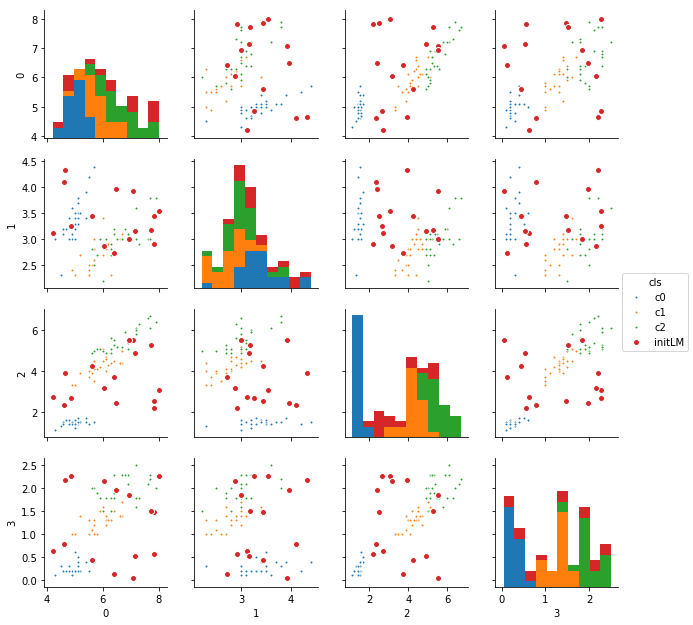

In [87]:
df = pd.DataFrame(np.r_[xtrain, init_lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o'], hue='cls', size=2.2, diag_kind='hist')

In [88]:
%%time
#hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, ytrain, epochs=500, verbose=0)

CPU times: user 4.62 s, sys: 176 ms, total: 4.8 s
Wall time: 3.94 s


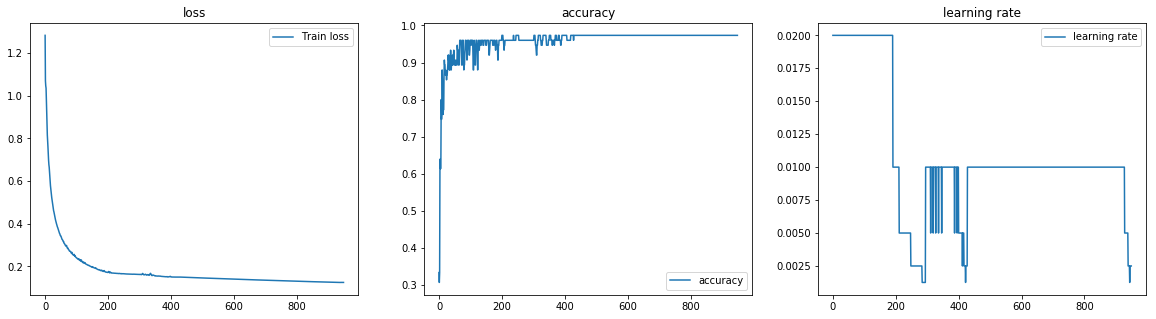

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [90]:
1 / (4*xtrain.var()), 1/(2*np.sqrt(4/6)*2)

(0.06392857199469391, 0.30618621784789724)

In [91]:
'''
gamma
'''
clf.current_gamma()

0.063928574

In [92]:
'''
trained nothing
'''
lm = clf.current_lm()
lm

array([[7.9995184 , 3.5396101 , 3.0662866 , 2.2683778 ],
       [7.834507  , 3.4401708 , 2.520432  , 1.4781429 ],
       [5.5989285 , 3.4453743 , 4.239085  , 0.4369025 ],
       [4.62921   , 4.098932  , 2.3350592 , 0.7847965 ],
       [6.413307  , 2.7227895 , 3.7233336 , 0.11886923],
       [7.833985  , 2.9079428 , 2.2015417 , 0.56544316],
       [7.0617323 , 3.924635  , 5.5146265 , 0.04209496],
       [6.0504866 , 2.8765032 , 3.1498928 , 2.1507907 ],
       [4.857594  , 3.2590787 , 2.668152  , 2.2741756 ],
       [4.220257  , 3.1119807 , 2.7293522 , 0.6253608 ],
       [7.1442175 , 3.1661725 , 4.9058228 , 0.5285508 ],
       [6.486178  , 3.9649353 , 2.413418  , 1.9647139 ],
       [4.640807  , 4.3265414 , 3.9232376 , 2.1915011 ],
       [6.9367194 , 2.993304  , 5.5345726 , 1.8462281 ],
       [7.72698   , 3.1720166 , 5.255798  , 1.5139724 ]], dtype=float32)

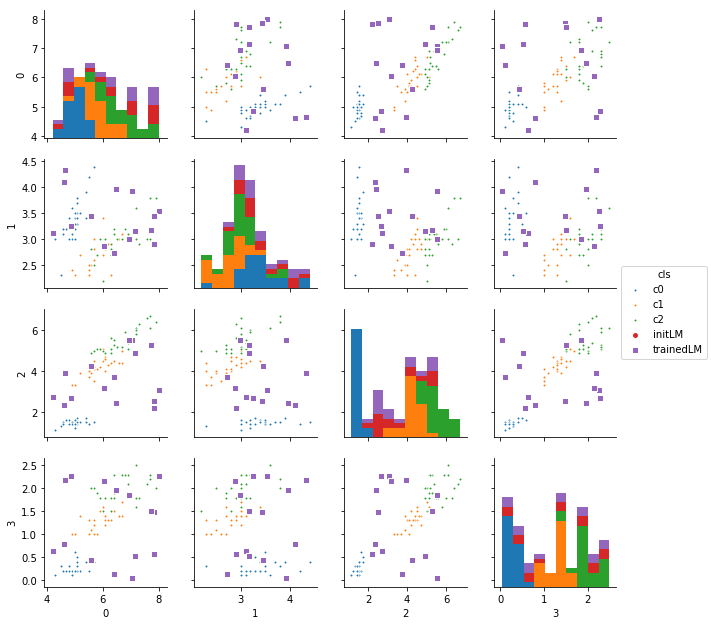

In [93]:
df = pd.DataFrame(np.r_[xtrain, init_lm, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0] + ['trainedLM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o','s'], hue='cls', size=2.2, diag_kind='hist')

In [94]:
clf.predict_proba(xtest)[:5]

array([[9.85189378e-01, 1.47962281e-02, 1.43241359e-05],
       [9.92927611e-01, 7.05800718e-03, 1.43355455e-05],
       [9.88245726e-01, 1.17403762e-02, 1.38895457e-05],
       [9.93366659e-01, 6.61981711e-03, 1.34410620e-05],
       [9.93781984e-01, 6.19714707e-03, 2.07927696e-05]], dtype=float32)

In [95]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [96]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9732905982905983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.92      0.96        25
           2       0.93      1.00      0.96        25

   micro avg       0.97      0.97      0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75

[[25  0  0]
 [ 0 23  2]
 [ 0  0 25]]


In [97]:
pred_test = clf.predict(xtest)

In [98]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9333066559957316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.88      0.92      0.90        25
           2       0.92      0.88      0.90        25

   micro avg       0.93      0.93      0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75

[[25  0  0]
 [ 0 23  2]
 [ 0  3 22]]


## vector input

In [99]:
num_lm = 15
init_lm = np.c_[
    np.random.random((num_lm,))*4+4,
    np.random.random((num_lm,))*2+2.5,
    np.random.random((num_lm,))*4+2,
    np.random.random((num_lm,))*2.5
]

clf = RBFClassifier(
    num_lm=num_lm,
    lm=init_lm,
    gamma='scale',
    make_model_gkernel=make_model_gkernel1
)

In [100]:
init_lm

array([[5.48340972, 4.14605381, 3.00177061, 1.28146903],
       [4.40232015, 2.7386    , 3.4102843 , 0.36421836],
       [5.21572386, 3.38444149, 4.86174054, 0.91111126],
       [4.28548823, 3.86363278, 2.09902019, 0.73108237],
       [5.24336721, 3.58520285, 5.89095988, 0.54824596],
       [5.67007596, 2.73475685, 5.80723316, 1.24322082],
       [7.73800897, 3.29655305, 2.61433398, 1.5443523 ],
       [7.96829166, 3.62265008, 5.17380493, 0.98054517],
       [6.10457365, 4.25239961, 3.52370327, 1.14553649],
       [6.13288077, 4.40160181, 2.80109288, 1.64568466],
       [4.76466307, 3.79155155, 2.98806595, 0.34997609],
       [6.67030097, 3.87524452, 4.91721169, 1.10981451],
       [6.21593959, 3.78900785, 2.87464189, 1.81409427],
       [7.99846571, 4.43194598, 4.43715788, 1.70155959],
       [6.18744601, 4.09820501, 5.38667975, 0.96857394]])

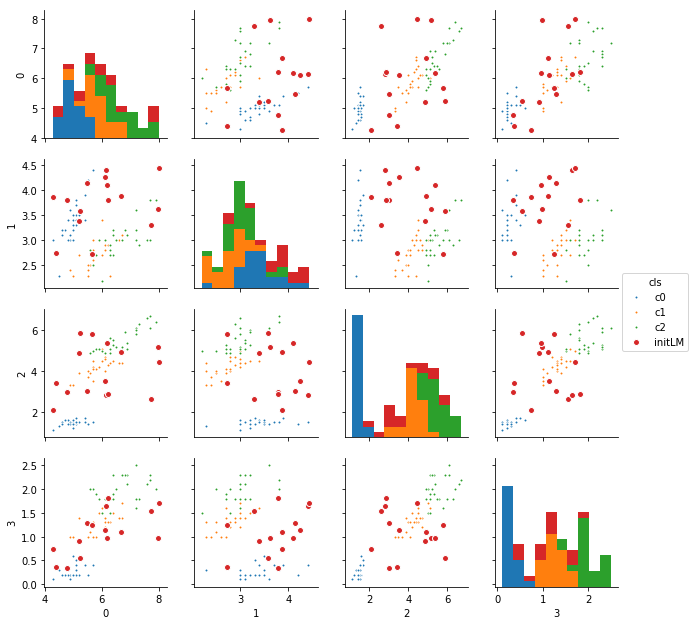

In [101]:
df = pd.DataFrame(np.r_[xtrain, init_lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o'], hue='cls', size=2.2, diag_kind='hist')

In [102]:
ytrain[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [103]:
np.argmax(ytrain, axis=1)[:5]

array([0, 0, 0, 0, 0])

In [104]:
%%time
#hst = clf.fit(xtrain, np.argmax(ytrain, axis=1), epochs=500, batch_size=256, verbose=0)
hst = clf.fit(xtrain, np.argmax(ytrain, axis=1), epochs=500, verbose=0)

CPU times: user 4.14 s, sys: 116 ms, total: 4.25 s
Wall time: 3.53 s


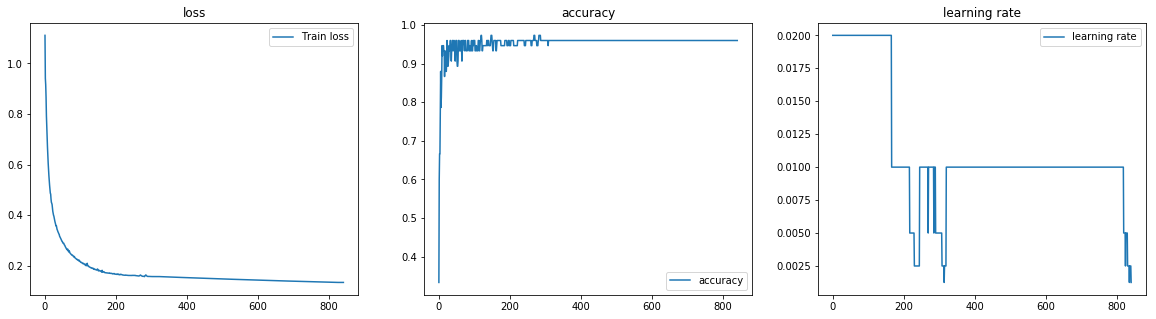

In [105]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [106]:
1 / (4*xtrain.var()), 1/(2*np.sqrt(4/6)*2)

(0.06392857199469391, 0.30618621784789724)

In [107]:
'''
gamma
'''
clf.current_gamma()

0.063928574

In [108]:
'''
trained nothing
'''
lm = clf.current_lm()
lm

array([[5.48341   , 4.146054  , 3.0017705 , 1.281469  ],
       [4.4023204 , 2.7386    , 3.4102843 , 0.36421835],
       [5.215724  , 3.3844414 , 4.8617406 , 0.91111124],
       [4.285488  , 3.8636327 , 2.0990202 , 0.7310824 ],
       [5.243367  , 3.585203  , 5.8909597 , 0.54824597],
       [5.670076  , 2.734757  , 5.8072333 , 1.2432208 ],
       [7.738009  , 3.2965531 , 2.6143339 , 1.5443523 ],
       [7.9682918 , 3.6226501 , 5.1738048 , 0.98054516],
       [6.1045737 , 4.2523994 , 3.5237033 , 1.1455365 ],
       [6.1328807 , 4.401602  , 2.8010929 , 1.6456847 ],
       [4.764663  , 3.7915516 , 2.988066  , 0.3499761 ],
       [6.670301  , 3.8752446 , 4.9172115 , 1.1098145 ],
       [6.2159395 , 3.789008  , 2.874642  , 1.8140943 ],
       [7.9984655 , 4.431946  , 4.437158  , 1.7015595 ],
       [6.187446  , 4.098205  , 5.3866796 , 0.9685739 ]], dtype=float32)

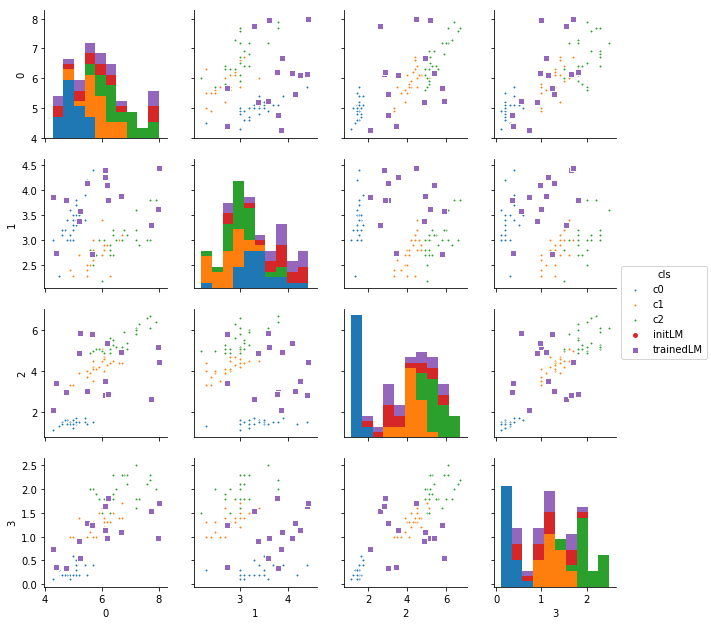

In [109]:
df = pd.DataFrame(np.r_[xtrain, init_lm, lm])
df['cls'] = ['c'+str(ee) for ee in np.argmax(ytrain, axis=1)] + ['initLM']*init_lm.shape[0] + ['trainedLM']*lm.shape[0]
df.head()

fig = sns.pairplot(df, markers=['.']*3+['o','s'], hue='cls', size=2.2, diag_kind='hist')

In [110]:
clf.predict_proba(xtest)[:5]

array([[9.8808962e-01, 1.1908830e-02, 1.5841389e-06],
       [9.9334347e-01, 6.6550151e-03, 1.5335469e-06],
       [9.8993874e-01, 1.0059998e-02, 1.3340797e-06],
       [9.9322850e-01, 6.7703845e-03, 1.1349246e-06],
       [9.9339759e-01, 6.6000656e-03, 2.4068147e-06]], dtype=float32)

In [111]:
pred = clf.predict(xtrain)
pred[:5]

array([0, 0, 0, 0, 0])

In [112]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9599839935974389
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      0.92      0.94        25
           2       0.92      0.96      0.94        25

   micro avg       0.96      0.96      0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

[[25  0  0]
 [ 0 23  2]
 [ 0  1 24]]


In [113]:
pred_test = clf.predict(xtest)

In [114]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9066293183940243
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.88      0.84      0.86        25
           2       0.85      0.88      0.86        25

   micro avg       0.91      0.91      0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

[[25  0  0]
 [ 0 21  4]
 [ 0  3 22]]


## Regressor

In [115]:
est = RBFRegressor(
    num_lm=30,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 30)],
    make_model_gkernel=make_model_gkernel3
)
# est = RBFRegressor(
#     num_lm=10,
#     lm=xtrain[:10],
#     make_model_gkernel=make_model_gkernel3,
#     loss='mae'
# )

In [116]:
%%time
#hst = est.fit(xtrain, np.argmax(ytrain, axis=1), epochs=500, batch_size=256, verbose=0)
hst = est.fit(xtrain, np.argmax(ytrain, axis=1), epochs=500, verbose=0)

CPU times: user 1.72 s, sys: 17.8 ms, total: 1.74 s
Wall time: 1.61 s


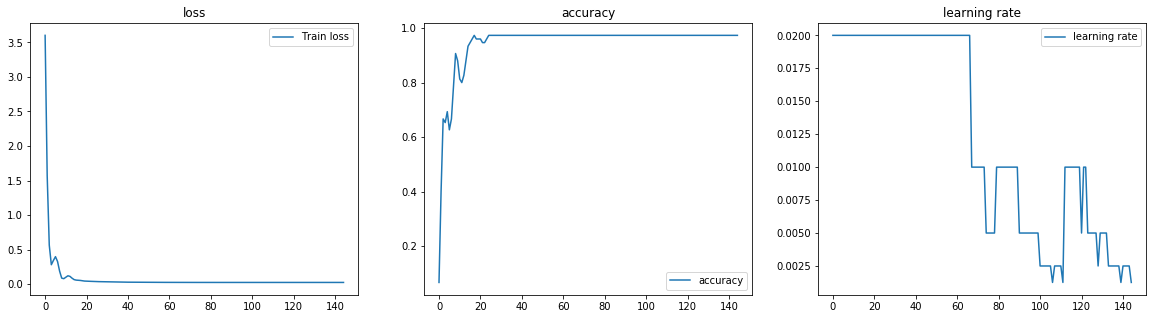

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [118]:
est.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 4)                 0         
_________________________________________________________________
model_gkernel (Model)        (None, 30)                121       
_________________________________________________________________
model_out (Model)            (None, 1)                 31        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [119]:
est.predict(xtrain)

array([ 1.5951395e-03,  2.2568285e-02,  3.0146867e-02, -5.1128268e-03,
        2.5923669e-02,  3.0219615e-02, -5.6456029e-02,  3.0305535e-02,
       -4.1720033e-02, -2.0463198e-02, -2.1022856e-02,  8.2947195e-02,
        7.6110899e-02, -8.3577335e-03,  4.8161954e-02,  7.3364377e-03,
       -5.5792034e-03, -7.1469545e-02, -3.4141243e-02, -3.6217272e-03,
        7.2679490e-02,  2.9852629e-02, -2.3972392e-03, -1.8630505e-02,
       -2.8022736e-02,  9.9478763e-01,  1.2045975e+00,  1.2024678e+00,
        8.8298762e-01,  1.1227658e+00,  1.0745981e+00,  1.2818650e+00,
        8.1853414e-01,  8.7491167e-01,  9.9773306e-01,  8.9357853e-01,
        1.1456888e+00,  9.0049613e-01,  1.5625217e+00,  7.9029477e-01,
        9.3620515e-01,  1.7487268e+00,  1.0118508e+00,  1.1803162e+00,
        1.1628065e+00,  1.1705241e+00,  8.9700192e-01,  9.1958714e-01,
        9.5500153e-01,  1.0525690e+00,  1.9472456e+00,  2.0204706e+00,
        1.9960058e+00,  2.0104949e+00,  2.0619659e+00,  2.0734735e+00,
      

In [120]:
est.__dict__

{'build_fn': <function gkernel.sklearn.make_model>,
 'model': <keras.engine.training.Model at 0x7f2c08e36cc0>,
 'sk_params': {'activation': 'linear',
  'callbacks': None,
  'lm': array([[5.5, 2.5, 4. , 1.3],
         [6.7, 3.1, 4.4, 1.4],
         [6.4, 3.2, 5.3, 2.3],
         [4.8, 3.4, 1.6, 0.2],
         [4.9, 3.1, 1.5, 0.1],
         [7.7, 3.8, 6.7, 2.2],
         [4.8, 3. , 1.4, 0.3],
         [5.1, 3.7, 1.5, 0.4],
         [7.3, 2.9, 6.3, 1.8],
         [7.2, 3. , 5.8, 1.6],
         [7.2, 3. , 5.8, 1.6],
         [6.4, 3.2, 4.5, 1.5],
         [6.4, 2.7, 5.3, 1.9],
         [6.1, 2.8, 4. , 1.3],
         [6.1, 3. , 4.9, 1.8],
         [6.4, 3.1, 5.5, 1.8],
         [4.3, 3. , 1.1, 0.1],
         [6.5, 3. , 5.2, 2. ],
         [5.7, 4.4, 1.5, 0.4],
         [5.5, 2.5, 4. , 1.3],
         [5.1, 3.7, 1.5, 0.4],
         [6.1, 3. , 4.9, 1.8],
         [7.2, 3. , 5.8, 1.6],
         [6.6, 3. , 4.4, 1.4],
         [5.7, 4.4, 1.5, 0.4],
         [4.9, 3. , 1.4, 0.2],
         [6.4, 3.

In [121]:
est.score(xtrain, np.argmax(ytrain, axis=1))

75/75 [==============================] - 0s 2ms/step


-0.02641723267734051

In [122]:
est.score(xtest, np.argmax(yans, axis=1))

75/75 [==============================] - 0s 53us/step


-0.03644815067450206